# Research Question 1: River extent of influence

What is the spatial extent of influence of the river contribution to surface waters in the CAA?
- Does the RCD span full straits in the CAA? If so, which and during all seasons or only for a portion of the year?
- How long does it take for river contributions in the central CAA to reach Baffin Bay?

Correlate the time series of discharge and fluxes

In [1]:
import os
os.environ['PROJ_LIB'] = '/home/brogalla/anaconda3/share/proj'

In [2]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from dateutil.relativedelta import relativedelta
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import netCDF4 as nc
from itertools import compress
import datetime as dt
from scipy.signal import find_peaks
import seaborn as sns; sns.set()
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

##### Load domain dimensions for reference:

In [3]:
imin, imax = 1480, 2050
jmin, jmax = 160, 800

In [4]:
mask  = nc.Dataset('/ocean/brogalla/GEOTRACES/ariane_runs/ANHA12_Ariane_mesh.nc')
tmask = np.array(mask.variables['tmask'])
cond = (tmask[0,:,:,:] > 0.1) 
land_mask = np.ma.masked_where(cond, tmask[0,:,:,:])

mesh  = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12-EXH006_5d_gridT_y2002m01d05.nc')
lons  = np.array(mesh.variables['nav_lon'])
lats  = np.array(mesh.variables['nav_lat'])
tmask = tmask[0,:,imin:imax,jmin:jmax]

In [5]:
ref   = nc.Dataset('/data/brogalla/run_storage/trial4/ref-2003/ANHA12_EXH006_2003_monthly.nc',  'r')
tlons = np.array(ref.variables['nav_lon'])
tlats = np.array(ref.variables['nav_lat'])
depth = np.array(ref.variables['deptht'])

##### Load boundary coordinates:

In [6]:
l1i = 2013-imin; l1j = np.arange(300-jmin,392-jmin)
l2i = 1935-imin; l2j = np.arange(450-jmin,530-jmin)
l3i = np.arange(1850-imin,1885-imin); l3j = 555-jmin
l4i = np.arange(1753-imin,1837-imin); l4j = 568-jmin
l5i = np.arange(1720-imin,1790-imin); l5j = 605-jmin
l6i = 1730-imin; l6j = np.arange(660-jmin,690-jmin)

t1i = np.arange(1635-imin,1653-imin); t1j = 760-jmin

r1i = 1520-imin; r1j = np.arange(505-jmin,673-jmin)
r2i = 1520-imin; r2j = np.arange(385-jmin,405-jmin)

N1i = np.arange(1570-imin,1630-imin); N1j = 635-jmin #Nares
P1i = 1585-imin; P1j = np.arange(485-jmin,538-jmin)  #Parry channel

#### Load pickled time series calculations (5d):

In [7]:
def time_series_pickle(year, riv_2a=False, riv_2b=False):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # Load calculated time series of fluxes:
    if riv_2a:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'time-series-20190930-riv-2a'+str(year)+'.pickle','rb'))  
    elif riv_2b:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
            pickle.load(open(folder+'time-series-20190930-riv-2b'+str(year)+'.pickle','rb'))  
    else:
        time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
        time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
        time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
        time_series_mn9, time_series_mn10, time_series_mn11 = \
                pickle.load(open(folder+'time-series-20190930-ref'+str(year)+'.pickle','rb'))
    
    # Conservation of volume check:
    sum_V = -1*np.sum(time_series_V1,axis=2) - np.sum(time_series_V2,axis=2) - np.sum(time_series_V7,axis=2) - \
           (np.sum(time_series_V3,axis=2) + np.sum(time_series_V4,axis=2) + np.sum(time_series_V5,axis=2) + \
            np.sum(time_series_V6,axis=2)) + np.sum(time_series_V8,axis=2) + np.sum(time_series_V9,axis=2)
#     print('Total volume change at end of time period: ', np.sum(sum_V))
    
    # Combine western CAA time series:
    time_series_mn_WCAA = np.sum(np.sum(time_series_mn3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_mn6,axis=2),axis=1)
    time_series_V_WCAA = np.sum(np.sum(time_series_V3,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V4,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V5,axis=2),axis=1) + \
                    np.sum(np.sum(time_series_V6,axis=2),axis=1)
    
    return time_series_mn1, time_series_mn2, time_series_mn_WCAA, time_series_mn7, time_series_mn8, \
            time_series_mn9, time_series_mn10, time_series_mn11

In [8]:
ts_2002_mn1, ts_2002_mn2, ts_2002_mn_WCAA, ts_2002_mn7, ts_2002_mn8, ts_2002_mn9, ts_2002_mn10, ts_2002_mn11 = time_series_pickle(2002)
ts_2003_mn1, ts_2003_mn2, ts_2003_mn_WCAA, ts_2003_mn7, ts_2003_mn8, ts_2003_mn9, ts_2003_mn10, ts_2003_mn11 = time_series_pickle(2003)
ts_2004_mn1, ts_2004_mn2, ts_2004_mn_WCAA, ts_2004_mn7, ts_2004_mn8, ts_2004_mn9, ts_2004_mn10, ts_2004_mn11 = time_series_pickle(2004)
ts_2005_mn1, ts_2005_mn2, ts_2005_mn_WCAA, ts_2005_mn7, ts_2005_mn8, ts_2005_mn9, ts_2005_mn10, ts_2005_mn11 = time_series_pickle(2005)
ts_2006_mn1, ts_2006_mn2, ts_2006_mn_WCAA, ts_2006_mn7, ts_2006_mn8, ts_2006_mn9, ts_2006_mn10, ts_2006_mn11 = time_series_pickle(2006)
ts_2007_mn1, ts_2007_mn2, ts_2007_mn_WCAA, ts_2007_mn7, ts_2007_mn8, ts_2007_mn9, ts_2007_mn10, ts_2007_mn11 = time_series_pickle(2007)
ts_2008_mn1, ts_2008_mn2, ts_2008_mn_WCAA, ts_2008_mn7, ts_2008_mn8, ts_2008_mn9, ts_2008_mn10, ts_2008_mn11 = time_series_pickle(2008)
ts_2009_mn1, ts_2009_mn2, ts_2009_mn_WCAA, ts_2009_mn7, ts_2009_mn8, ts_2009_mn9, ts_2009_mn10, ts_2009_mn11 = time_series_pickle(2009)
ts_2010_mn1, ts_2010_mn2, ts_2010_mn_WCAA, ts_2010_mn7, ts_2010_mn8, ts_2010_mn9, ts_2010_mn10, ts_2010_mn11 = time_series_pickle(2010)
ts_2011_mn1, ts_2011_mn2, ts_2011_mn_WCAA, ts_2011_mn7, ts_2011_mn8, ts_2011_mn9, ts_2011_mn10, ts_2011_mn11 = time_series_pickle(2011)
ts_2012_mn1, ts_2012_mn2, ts_2012_mn_WCAA, ts_2012_mn7, ts_2012_mn8, ts_2012_mn9, ts_2012_mn10, ts_2012_mn11 = time_series_pickle(2012)
ts_2013_mn1, ts_2013_mn2, ts_2013_mn_WCAA, ts_2013_mn7, ts_2013_mn8, ts_2013_mn9, ts_2013_mn10, ts_2013_mn11 = time_series_pickle(2013)
ts_2014_mn1, ts_2014_mn2, ts_2014_mn_WCAA, ts_2014_mn7, ts_2014_mn8, ts_2014_mn9, ts_2014_mn10, ts_2014_mn11 = time_series_pickle(2014)
ts_2015_mn1, ts_2015_mn2, ts_2015_mn_WCAA, ts_2015_mn7, ts_2015_mn8, ts_2015_mn9, ts_2015_mn10, ts_2015_mn11 = time_series_pickle(2015)
ts_2016_mn1, ts_2016_mn2, ts_2016_mn_WCAA, ts_2016_mn7, ts_2016_mn8, ts_2016_mn9, ts_2016_mn10, ts_2016_mn11 = time_series_pickle(2016)
ts_2017_mn1, ts_2017_mn2, ts_2017_mn_WCAA, ts_2017_mn7, ts_2017_mn8, ts_2017_mn9, ts_2017_mn10, ts_2017_mn11 = time_series_pickle(2017)
ts_2018_mn1, ts_2018_mn2, ts_2018_mn_WCAA, ts_2018_mn7, ts_2018_mn8, ts_2018_mn9, ts_2018_mn10, ts_2018_mn11 = time_series_pickle(2018)

In [9]:
riv_2002_mn1, riv_2002_mn2, riv_2002_mn_WCAA, riv_2002_mn7, riv_2002_mn8, riv_2002_mn9, riv_2002_mn10, riv_2002_mn11 = time_series_pickle(2002, riv_2a=True)
riv_2003_mn1, riv_2003_mn2, riv_2003_mn_WCAA, riv_2003_mn7, riv_2003_mn8, riv_2003_mn9, riv_2003_mn10, riv_2003_mn11 = time_series_pickle(2003, riv_2a=True)
riv_2004_mn1, riv_2004_mn2, riv_2004_mn_WCAA, riv_2004_mn7, riv_2004_mn8, riv_2004_mn9, riv_2004_mn10, riv_2004_mn11 = time_series_pickle(2004, riv_2a=True)
riv_2005_mn1, riv_2005_mn2, riv_2005_mn_WCAA, riv_2005_mn7, riv_2005_mn8, riv_2005_mn9, riv_2005_mn10, riv_2005_mn11 = time_series_pickle(2005, riv_2a=True)
riv_2006_mn1, riv_2006_mn2, riv_2006_mn_WCAA, riv_2006_mn7, riv_2006_mn8, riv_2006_mn9, riv_2006_mn10, riv_2006_mn11 = time_series_pickle(2006, riv_2a=True)
riv_2007_mn1, riv_2007_mn2, riv_2007_mn_WCAA, riv_2007_mn7, riv_2007_mn8, riv_2007_mn9, riv_2007_mn10, riv_2007_mn11 = time_series_pickle(2007, riv_2a=True)
riv_2008_mn1, riv_2008_mn2, riv_2008_mn_WCAA, riv_2008_mn7, riv_2008_mn8, riv_2008_mn9, riv_2008_mn10, riv_2008_mn11 = time_series_pickle(2008, riv_2a=True)
riv_2009_mn1, riv_2009_mn2, riv_2009_mn_WCAA, riv_2009_mn7, riv_2009_mn8, riv_2009_mn9, riv_2009_mn10, riv_2009_mn11 = time_series_pickle(2009, riv_2a=True)
riv_2010_mn1, riv_2010_mn2, riv_2010_mn_WCAA, riv_2010_mn7, riv_2010_mn8, riv_2010_mn9, riv_2010_mn10, riv_2010_mn11 = time_series_pickle(2010, riv_2a=True)
riv_2011_mn1, riv_2011_mn2, riv_2011_mn_WCAA, riv_2011_mn7, riv_2011_mn8, riv_2011_mn9, riv_2011_mn10, riv_2011_mn11 = time_series_pickle(2011, riv_2a=True)
riv_2012_mn1, riv_2012_mn2, riv_2012_mn_WCAA, riv_2012_mn7, riv_2012_mn8, riv_2012_mn9, riv_2012_mn10, riv_2012_mn11 = time_series_pickle(2012, riv_2a=True)
riv_2013_mn1, riv_2013_mn2, riv_2013_mn_WCAA, riv_2013_mn7, riv_2013_mn8, riv_2013_mn9, riv_2013_mn10, riv_2013_mn11 = time_series_pickle(2013, riv_2a=True)
riv_2014_mn1, riv_2014_mn2, riv_2014_mn_WCAA, riv_2014_mn7, riv_2014_mn8, riv_2014_mn9, riv_2014_mn10, riv_2014_mn11 = time_series_pickle(2014, riv_2a=True)
riv_2015_mn1, riv_2015_mn2, riv_2015_mn_WCAA, riv_2015_mn7, riv_2015_mn8, riv_2015_mn9, riv_2015_mn10, riv_2015_mn11 = time_series_pickle(2015, riv_2a=True)
riv_2016_mn1, riv_2016_mn2, riv_2016_mn_WCAA, riv_2016_mn7, riv_2016_mn8, riv_2016_mn9, riv_2016_mn10, riv_2016_mn11 = time_series_pickle(2016, riv_2a=True)
riv_2017_mn1, riv_2017_mn2, riv_2017_mn_WCAA, riv_2017_mn7, riv_2017_mn8, riv_2017_mn9, riv_2017_mn10, riv_2017_mn11 = time_series_pickle(2017, riv_2a=True)
riv_2018_mn1, riv_2018_mn2, riv_2018_mn_WCAA, riv_2018_mn7, riv_2018_mn8, riv_2018_mn9, riv_2018_mn10, riv_2018_mn11 = time_series_pickle(2018, riv_2a=True)

In [10]:
con_2002_mn1, con_2002_mn2, con_2002_mn_WCAA, con_2002_mn7, con_2002_mn8, con_2002_mn9, con_2002_mn10, con_2002_mn11 = time_series_pickle(2002, riv_2b=True)
con_2003_mn1, con_2003_mn2, con_2003_mn_WCAA, con_2003_mn7, con_2003_mn8, con_2003_mn9, con_2003_mn10, con_2003_mn11 = time_series_pickle(2003, riv_2b=True)
con_2004_mn1, con_2004_mn2, con_2004_mn_WCAA, con_2004_mn7, con_2004_mn8, con_2004_mn9, con_2004_mn10, con_2004_mn11 = time_series_pickle(2004, riv_2b=True)
con_2005_mn1, con_2005_mn2, con_2005_mn_WCAA, con_2005_mn7, con_2005_mn8, con_2005_mn9, con_2005_mn10, con_2005_mn11 = time_series_pickle(2005, riv_2b=True)
con_2006_mn1, con_2006_mn2, con_2006_mn_WCAA, con_2006_mn7, con_2006_mn8, con_2006_mn9, con_2006_mn10, con_2006_mn11 = time_series_pickle(2006, riv_2b=True)
con_2007_mn1, con_2007_mn2, con_2007_mn_WCAA, con_2007_mn7, con_2007_mn8, con_2007_mn9, con_2007_mn10, con_2007_mn11 = time_series_pickle(2007, riv_2b=True)
con_2008_mn1, con_2008_mn2, con_2008_mn_WCAA, con_2008_mn7, con_2008_mn8, con_2008_mn9, con_2008_mn10, con_2008_mn11 = time_series_pickle(2008, riv_2b=True)
con_2009_mn1, con_2009_mn2, con_2009_mn_WCAA, con_2009_mn7, con_2009_mn8, con_2009_mn9, con_2009_mn10, con_2009_mn11 = time_series_pickle(2009, riv_2b=True)
con_2010_mn1, con_2010_mn2, con_2010_mn_WCAA, con_2010_mn7, con_2010_mn8, con_2010_mn9, con_2010_mn10, con_2010_mn11 = time_series_pickle(2010, riv_2b=True)
con_2011_mn1, con_2011_mn2, con_2011_mn_WCAA, con_2011_mn7, con_2011_mn8, con_2011_mn9, con_2011_mn10, con_2011_mn11 = time_series_pickle(2011, riv_2b=True)
con_2012_mn1, con_2012_mn2, con_2012_mn_WCAA, con_2012_mn7, con_2012_mn8, con_2012_mn9, con_2012_mn10, con_2012_mn11 = time_series_pickle(2012, riv_2b=True)
con_2013_mn1, con_2013_mn2, con_2013_mn_WCAA, con_2013_mn7, con_2013_mn8, con_2013_mn9, con_2013_mn10, con_2013_mn11 = time_series_pickle(2013, riv_2b=True)
con_2014_mn1, con_2014_mn2, con_2014_mn_WCAA, con_2014_mn7, con_2014_mn8, con_2014_mn9, con_2014_mn10, con_2014_mn11 = time_series_pickle(2014, riv_2b=True)
con_2015_mn1, con_2015_mn2, con_2015_mn_WCAA, con_2015_mn7, con_2015_mn8, con_2015_mn9, con_2015_mn10, con_2015_mn11 = time_series_pickle(2015, riv_2b=True)
con_2016_mn1, con_2016_mn2, con_2016_mn_WCAA, con_2016_mn7, con_2016_mn8, con_2016_mn9, con_2016_mn10, con_2016_mn11 = time_series_pickle(2016, riv_2b=True)
con_2017_mn1, con_2017_mn2, con_2017_mn_WCAA, con_2017_mn7, con_2017_mn8, con_2017_mn9, con_2017_mn10, con_2017_mn11 = time_series_pickle(2017, riv_2b=True)
con_2018_mn1, con_2018_mn2, con_2018_mn_WCAA, con_2018_mn7, con_2018_mn8, con_2018_mn9, con_2018_mn10, con_2018_mn11 = time_series_pickle(2018, riv_2b=True)

### Time series across boundaries:

- Positive --- into domain
- Negative --- out of domain

In [11]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1E = np.sort(os.listdir('/data/brogalla/run_storage/ref-'+str(year)+'/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

In [12]:
dates_2002 = file_dates(2002); dates_2003 = file_dates(2003); dates_2004 = file_dates(2004);
dates_2005 = file_dates(2005); dates_2006 = file_dates(2006); dates_2007 = file_dates(2007);
dates_2008 = file_dates(2008); dates_2009 = file_dates(2009); dates_2010 = file_dates(2010);
dates_2011 = file_dates(2011); dates_2012 = file_dates(2012); dates_2013 = file_dates(2013);
dates_2014 = file_dates(2014); dates_2015 = file_dates(2015); dates_2016 = file_dates(2016);
dates_2017 = file_dates(2017); dates_2018 = file_dates(2018);

In [13]:
dates = np.array(dates_2002+dates_2003+dates_2004+dates_2005+dates_2006+dates_2007+dates_2008+dates_2009+\
                 dates_2010+dates_2011+dates_2012+dates_2013+dates_2014+dates_2015+dates_2016+dates_2017+dates_2018)

Separated by layer. Boundaries:
- PC1 --- Pout, mn11
- PC2 --- Pin, mn2
- N1  --- Nout, mn10
- N2  --- Nin, mn7

In [14]:
def flux_layer(top, bottom):
    in_BB_ref   = np.empty((17, 72))
    out_BB_ref  = np.empty((17, 72))
    in_N1_ref   = np.empty((17, 72))
    out_N1_ref  = np.empty((17, 72))
    in_PC1_ref  = np.empty((17, 72))
    out_PC1_ref = np.empty((17, 72))
    
    in_BB_riv2a   = np.empty((17, 72))
    out_BB_riv2a  = np.empty((17, 72))
    in_N1_riv2a   = np.empty((17, 72))
    out_N1_riv2a  = np.empty((17, 72))
    in_PC1_riv2a  = np.empty((17, 72))
    out_PC1_riv2a = np.empty((17, 72))
    
    in_BB_riv2b   = np.empty((17, 72))
    out_BB_riv2b  = np.empty((17, 72))
    in_N1_riv2b   = np.empty((17, 72))
    out_N1_riv2b  = np.empty((17, 72))
    in_PC1_riv2b  = np.empty((17, 72))
    out_PC1_riv2b = np.empty((17, 72))

    count = 0
    for year in range(2002, 2019):
        ts_year_mn1, ts_year_mn2, ts_year_mn_WCAA, ts_year_mn7, ts_year_mn8, ts_year_mn9, \
        ts_year_mn10, ts_year_mn11 = time_series_pickle(year)
        riv2a_year_mn1, riv2a_year_mn2, riv2a_year_mn_WCAA, riv2a_year_mn7, riv2a_year_mn8, riv2a_year_mn9, \
        riv2a_year_mn10, riv2a_year_mn11 = time_series_pickle(year, riv_2a=True)
        riv2b_year_mn1, riv2b_year_mn2, riv2b_year_mn_WCAA, riv2b_year_mn7, riv2b_year_mn8, riv2b_year_mn9, \
        riv2b_year_mn10, riv2b_year_mn11 = time_series_pickle(year, riv_2b=True)

        for date in range(0,72):
            in_BB_ref[count,date]     = -np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] >= 0])
            out_BB_ref[count,date]    = -np.sum(ts_year_mn8[date, top:bottom, :][ts_year_mn8[date, top:bottom, :] < 0])
            in_BB_riv2a[count,date]   = -np.sum(riv2a_year_mn8[date, top:bottom, :][riv2a_year_mn8[date, top:bottom, :] >= 0])
            out_BB_riv2a[count,date]  = -np.sum(riv2a_year_mn8[date, top:bottom, :][riv2a_year_mn8[date, top:bottom, :] < 0])
            in_BB_riv2b[count,date]   = -np.sum(riv2b_year_mn8[date, top:bottom, :][riv2b_year_mn8[date, top:bottom, :] >= 0])
            out_BB_riv2b[count,date]  = -np.sum(riv2b_year_mn8[date, top:bottom, :][riv2b_year_mn8[date, top:bottom, :] < 0])
            
            in_N1_ref[count,date]     = -np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] >= 0])
            out_N1_ref[count,date]    = -np.sum(ts_year_mn10[date, top:bottom, :][ts_year_mn10[date, top:bottom, :] < 0]) 
            in_N1_riv2a[count,date]   = -np.sum(riv2a_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] >= 0])
            out_N1_riv2a[count,date]  = -np.sum(riv2a_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] < 0]) 
            in_N1_riv2b[count,date]   = -np.sum(riv2b_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] >= 0])
            out_N1_riv2b[count,date]  = -np.sum(riv2b_year_mn10[date, top:bottom, :][riv2a_year_mn10[date, top:bottom, :] < 0]) 

            in_PC1_ref[count,date]     = -np.sum(ts_year_mn11[date, top:bottom, :][ts_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_ref[count,date]    = -np.sum(ts_year_mn11[date, top:bottom, :][ts_year_mn11[date, top:bottom, :] < 0]) 
            in_PC1_riv2a[count,date]   = -np.sum(riv2a_year_mn11[date, top:bottom, :][riv2a_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_riv2a[count,date]  = -np.sum(riv2a_year_mn11[date, top:bottom, :][riv2a_year_mn11[date, top:bottom, :] < 0]) 
            in_PC1_riv2b[count,date]   = -np.sum(riv2b_year_mn11[date, top:bottom, :][riv2b_year_mn11[date, top:bottom, :] >= 0])
            out_PC1_riv2b[count,date]  = -np.sum(riv2b_year_mn11[date, top:bottom, :][riv2b_year_mn11[date, top:bottom, :] < 0]) 

        count+=1
        
    return in_BB_ref, out_BB_ref, in_N1_ref, out_N1_ref, in_PC1_ref, out_PC1_ref, \
            in_BB_riv2a, out_BB_riv2a, in_N1_riv2a, out_N1_riv2a, in_PC1_riv2a, out_PC1_riv2a, \
            in_BB_riv2b, out_BB_riv2b, in_N1_riv2b, out_N1_riv2b, in_PC1_riv2b, out_PC1_riv2b

In [15]:
in_BB_ref_total, out_BB_ref_total, in_N1_ref_total, out_N1_ref_total, in_PC1_ref_total, out_PC1_ref_total,\
in_BB_riv2a_total, out_BB_riv2a_total, in_N1_riv2a_total, out_N1_riv2a_total, in_PC1_riv2a_total, \
out_PC1_riv2a_total, in_BB_riv2b_total, out_BB_riv2b_total, in_N1_riv2b_total, out_N1_riv2b_total, \
in_PC1_riv2b_total, out_PC1_riv2b_total = flux_layer(0, 50)

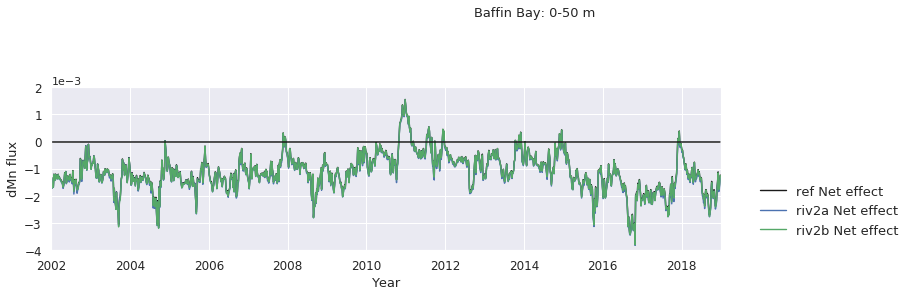

In [47]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

# ax.plot(dates, in_BB_ref_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='ref Entering the domain')
# ax.plot(dates, out_BB_ref_surf.flatten(), c='#b8ded3', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_BB_ref_surf.flatten()+in_BB_ref_surf.flatten(), c='k', linewidth=1.4, label='ref Net effect')

# ax.plot(dates, in_BB_riv2a_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='ref Entering the domain')
# ax.plot(dates, out_BB_riv2a_surf.flatten(), c='#b8ded3', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_BB_riv2a_surf.flatten()+in_BB_riv2a_surf.flatten(), c='b', linewidth=1.4, label='riv2a Net effect')

# ax.plot(dates, in_BB_riv2b_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='ref Entering the domain')
# ax.plot(dates, out_BB_riv2b_surf.flatten(), c='#b8ded3', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_BB_riv2b_surf.flatten()+in_BB_riv2b_surf.flatten(), c='g', linewidth=1.4, label='riv2b Net effect')

ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-4e-3, 2e-3])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
ax.text(dates_2012[-20], 4.6e-3, 'Baffin Bay: 0-50 m', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

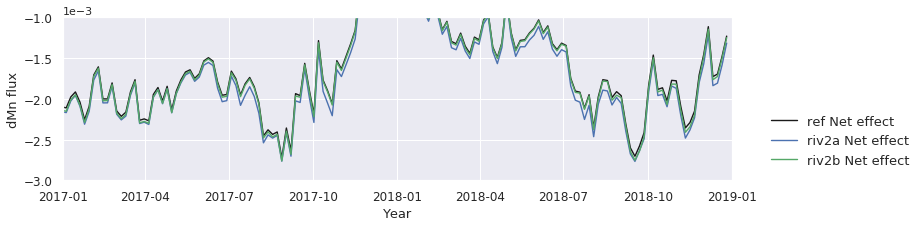

In [71]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

# ax.plot(dates, in_BB_ref_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='ref Entering the domain')
# ax.plot(dates, out_BB_ref_surf.flatten(), c='#b8ded3', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_BB_ref_surf.flatten()+in_BB_ref_surf.flatten(), c='k', linewidth=1.4, label='ref Net effect')

# ax.plot(dates, in_BB_riv2a_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='riv2a Entering the domain')
# ax.plot(dates, out_BB_riv2a_surf.flatten(), c='#b8ded3', linewidth=1.0, label='riv2a Leaving the domain')
ax.plot(dates, out_BB_riv2a_surf.flatten()+in_BB_riv2a_surf.flatten(), c='b', linewidth=1.4, label='riv2a Net effect')

# ax.plot(dates, in_BB_riv2b_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='riv2b Entering the domain')
# ax.plot(dates, out_BB_riv2b_surf.flatten(), c='#b8ded3', linewidth=1.0, label='riv2b Leaving the domain')
ax.plot(dates, out_BB_riv2b_surf.flatten()+in_BB_riv2b_surf.flatten(), c='g', linewidth=1.4, label='riv2b Net effect')

ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2017,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-3e-3, -1e-3])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
# ax.text(dates_2012[-20], 4.6e-3, 'Baffin Bay: 0-50 m', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

/home/brogalla/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


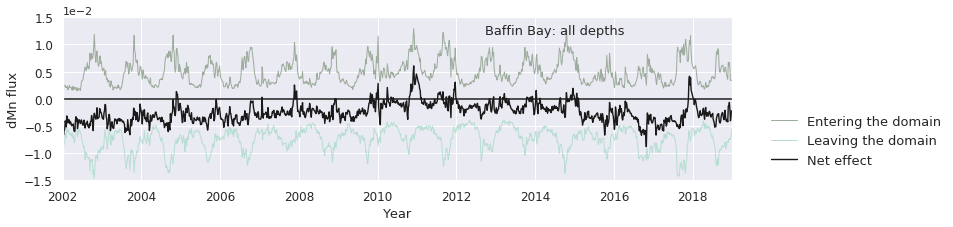

In [24]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

ax.plot(dates, in_BB_ref_total.flatten(),  c='#9dac9c', linewidth=1.0, label='Entering the domain')
ax.plot(dates, out_BB_ref_total.flatten(), c='#b8ded3', linewidth=1.0, label='Leaving the domain')
ax.plot(dates, out_BB_ref_total.flatten()+in_BB_ref_total.flatten(), c='k', linewidth=1.4, label='Net effect')
ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-1.5e-2, 1.5e-2])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
ax.text(dates_2012[-20], 1.2e-2, 'Baffin Bay: all depths', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

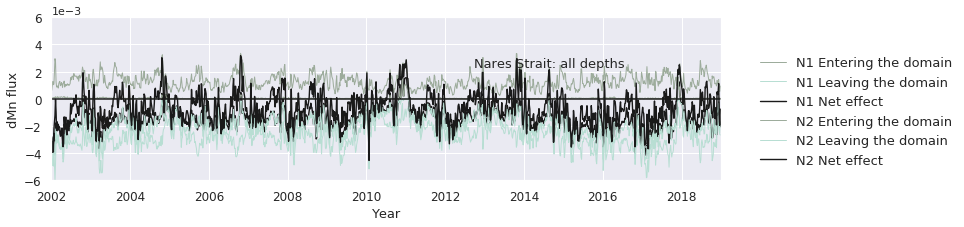

In [27]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

ax.plot(dates, in_N1_ref_total.flatten(),  c='#9dac9c', linewidth=1.0, label='N1 Entering the domain')
ax.plot(dates, out_N1_ref_total.flatten(), c='#b8ded3', linewidth=1.0, label='N1 Leaving the domain')
ax.plot(dates, out_N1_ref_total.flatten()+in_N1_ref_total.flatten(), c='k', linewidth=1.4, label='N1 Net effect')

ax.plot(dates, in_N2_ref_total.flatten(),  c='#9dac9c', linewidth=1.0, label='N2 Entering the domain')
ax.plot(dates, out_N2_ref_total.flatten(), c='#b8ded3', linewidth=1.0, label='N2 Leaving the domain')
ax.plot(dates, out_N2_ref_total.flatten()+in_N1_ref_total.flatten(), c='k', linewidth=1.4, label='N2 Net effect')

ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-6e-3, 6e-3])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
ax.text(dates_2012[-20], 4.3e-3, 'Nares Strait: all depths', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

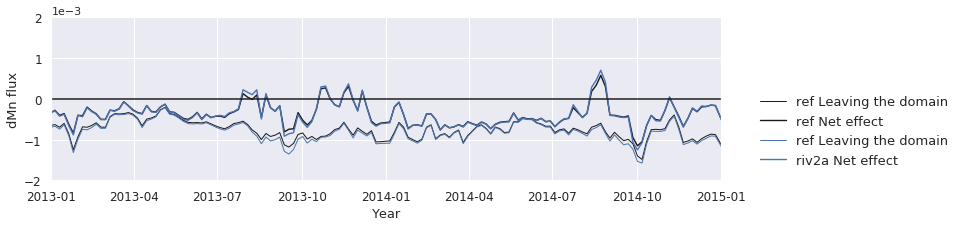

In [88]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

# ax.plot(dates, in_N_ref_surf.flatten(),  c='k', linewidth=1.0, label='ref Entering the domain')
ax.plot(dates, out_N_ref_surf.flatten(), c='k', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_N_ref_surf.flatten()+in_N_ref_surf.flatten(), c='k', linewidth=1.4, label='ref Net effect')

# ax.plot(dates, in_N_riv2a_surf.flatten(),  c='b', linewidth=1.0, label='ref Entering the domain')
ax.plot(dates, out_N_riv2a_surf.flatten(), c='b', linewidth=1.0, label='ref Leaving the domain')
ax.plot(dates, out_N_riv2a_surf.flatten()+in_N_riv2a_surf.flatten(), c='b', linewidth=1.4, label='riv2a Net effect')

# ax.plot(dates, in_N_riv2b_surf.flatten(),  c='#9dac9c', linewidth=1.0, label='ref Entering the domain')
# ax.plot(dates, out_N_riv2b_surf.flatten(), c='#b8ded3', linewidth=1.0, label='ref Leaving the domain')
# ax.plot(dates, out_N_riv2b_surf.flatten()+in_N_riv2b_surf.flatten(), c='g', linewidth=1.4, label='riv2b Net effect')

ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2013,1,1), dt.datetime(2015,1,1)])
ax.set_ylim([-2e-3, 2e-3])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
# ax.text(dates_2012[-20], 4.6e-3, 'Nares Strait: 0-50 m', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/N-time-series-20190925-surface.png', Nox_inches='tight')

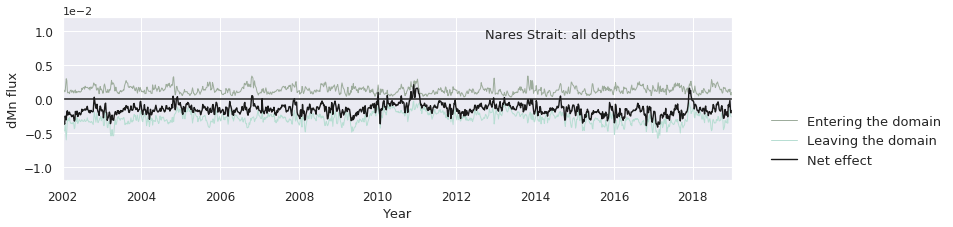

In [54]:
fig, ax = plt.subplots(1,1, figsize=(12,3))

ax.plot(dates, in_N1_ref_total.flatten(),  c='#9dac9c', linewidth=1.0, label='Entering the domain')
ax.plot(dates, out_N1_ref_total.flatten(), c='#b8ded3', linewidth=1.0, label='Leaving the domain')
ax.plot(dates, out_N1_ref_total.flatten()+in_N1_ref_total.flatten(), c='k', linewidth=1.4, label='Net effect')
ax.plot([dates_2002[0], dates_2018[-1]], [0, 0], '-k')

ax.set_xlim([dt.datetime(2002,1,1), dt.datetime(2019,1,1)])
ax.set_ylim([-1.2e-2, 1.2e-2])
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Year',fontsize=13)
ax.set_ylabel('dMn flux', fontsize=13)
ax.text(dates_2012[-20], 9e-3, 'Nares Strait: all depths', fontsize=13)

ax.legend(loc=(1.05, 0.05), frameon=False, fontsize=13)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/BB-time-series-20190925-surface.png', bbox_inches='tight')

Load river discharge information

In [16]:
rf = np.empty((18*12, imax-imin, jmax-jmin))

i=0
for year in range(2002, 2019):
    for month in range(0,12):
        c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y'+str(year)+'.nc','r')
        rf[i*12+month,:,:] = np.array(c.variables['runoff'])[month,imin:imax,jmin:jmax]
        
    i+=1

In [41]:
c = nc.Dataset('/data/brogalla/runoff/ANHA12_runoff_monthly_combined_Dai_Trenberth_Bamber_y2002.nc','r')
c.variables['runoff']

<class 'netCDF4._netCDF4.Variable'>
float32 runoff(time_counter, y, x)
    units: kg/s/m^2
unlimited dimensions: time_counter
current shape = (12, 2400, 1632)
filling on, default _FillValue of 9.969209968386869e+36 used

In [17]:
rf_time_series = np.sum(rf, axis=(1,2))

In [18]:
rclass = nc.Dataset('/ocean/brogalla/GEOTRACES/data/rivers/river_class_201807.nc','r')
river_class = rclass.variables['rclass']
river_class = np.array(river_class)

In [19]:
glacial_class = (river_class[1480:2050, 160:800]==1.0)
contine_class = (river_class[1480:2050, 160:800]==2.0)

In [20]:
griv = rf[:,:,:]*glacial_class
criv = rf[:,:,:]*contine_class

In [21]:
gc_time_series = np.sum(griv, axis=(1,2))
cn_time_series = np.sum(criv, axis=(1,2))

In [32]:
months = np.array([dates[2] + relativedelta(months=i) for i in range(0,18*12)])

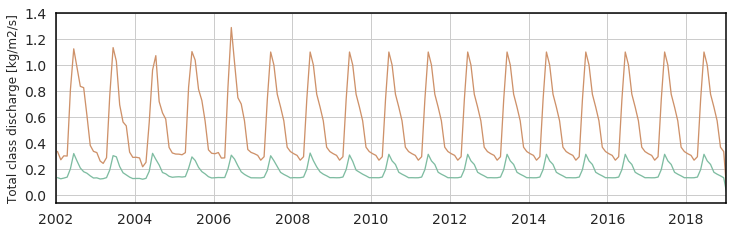

In [47]:
fig = plt.figure(figsize=(12,3.5))
st  = sns.axes_style("whitegrid")

with st:
#     ax = sns.lineplot(months, rf_time_series, linewidth=1.3, color='#007378')
    
    ax=sns.lineplot(months, gc_time_series, linewidth=1.3, color='#7ebca1')
    
    sns.lineplot(months, cn_time_series, linewidth=1.3, color='#ce9169')
    
#     sns.lineplot(dates, -1*out_BB_surf.flatten()/np.amax(np.abs(out_BB_surf)), linewidth=2.5, color='k')
    
#     ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.set(xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');
    
    ax.set_ylabel('Total class discharge [kg/m2/s]')

fig.savefig('/ocean/brogalla/GEOTRACES/figures/river-discharge.png', bbox_inches='tight', dpi=300)

# Correlate:

Normalize by maximum of Mn transport by rivers through boundary: only consider Baffin Bay-ward transport (i.e. east/south)

In [24]:
norm_rf = rf_time_series/np.amax(rf_time_series)
norm_gc = gc_time_series/np.amax(gc_time_series)
norm_cn = cn_time_series/np.amax(cn_time_series)

BB_gc = out_BB_riv2a_total.flatten() - out_BB_ref_total.flatten()
BB_cn = out_BB_riv2b_total.flatten() - out_BB_ref_total.flatten()
norm_BB_gc = BB_gc/np.amax(abs(BB_gc))
norm_BB_cn = BB_cn/np.amax(abs(BB_gc))

N1_gc = out_N1_riv2a_total.flatten() - out_N1_ref_total.flatten()
N1_cn = out_N1_riv2b_total.flatten() - out_N1_ref_total.flatten()
norm_N1_gc = N1_gc/np.amax(abs(N1_gc))
norm_N1_cn = N1_cn/np.amax(abs(N1_gc))

PC_gc = out_PC1_riv2a_total.flatten() - out_PC1_ref_total.flatten()
PC_cn = out_PC1_riv2b_total.flatten() - out_PC1_ref_total.flatten()
norm_PC_gc = PC_gc/np.amax(abs(PC_cn))
norm_PC_cn = PC_cn/np.amax(abs(PC_cn))

In [27]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    """

    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(int(np.floor(window_len/2)-1)):-(int(np.floor(window_len/2)))]

In [28]:
N1_gc_smooth = smooth(norm_N1_gc, window_len=30)
N1_cn_smooth = smooth(norm_N1_cn, window_len=30)

PC_gc_smooth = smooth(norm_PC_gc, window_len=30)
PC_cn_smooth = smooth(norm_PC_cn, window_len=40)

BB_gc_smooth = smooth(norm_BB_gc, window_len=50)
BB_cn_smooth = smooth(norm_BB_cn, window_len=50)

In [29]:
rf_i, _ = find_peaks(norm_rf, width=1, height=0.4)
gc_i, _ = find_peaks(norm_gc, width=1.5, height=0.4)
cn_i, _ = find_peaks(norm_cn, width=1, height=0.4)
BB_gci, _ = find_peaks(BB_gc_smooth, width=12, height=0.2)
BB_cni, _ = find_peaks(BB_cn_smooth, width=18, height=0.05)
N1_gci, _ = find_peaks(N1_gc_smooth, width=10, height=0.1)
N1_cni, _ = find_peaks(N1_cn_smooth, width=10, height=0.1)
PC_gci, _ = find_peaks(PC_gc_smooth, width=7,  height=0.1)
PC_cni, _ = find_peaks(PC_cn_smooth, width=20, height=0.05)

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PeakPropertyWarning: some peaks have a width of 0
  """


Better way for calculating time lag:

In [30]:
def check_lag(difference, date_river_peak, string, GC=True):
    if GC:
        if (np.amin(difference) < 200) & (np.amin(difference) > 40):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = []
                b = []
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    else:
        if (np.amin(difference) < 200) & (np.amin(difference) > 50):
                a = np.amin(difference)
                b = np.argmin(difference)
        else:
                a = []
                b = []
                print(string + ', probably false: ', date_river_peak, np.amin(difference))
    return a, b

In [31]:
time_lag_BB_gc = []
time_lag_PC_gc = []
time_lag_N1_gc = []
time_lag_BB_cn = []
time_lag_PC_cn = []

time_lag_BB_gc_date = []
time_lag_PC_gc_date = []
time_lag_N1_gc_date = []
time_lag_BB_cn_date = []
time_lag_PC_cn_date = []

for date_river_peak in months[gc_i]:
    diff_BB_gc = [abs((i-date_river_peak).days) for i in dates[BB_gci]]
    diff_PC_gc = [abs((i-date_river_peak).days) for i in dates[PC_gci]]
    diff_N1_gc = [abs((i-date_river_peak).days) for i in dates[N1_gci]]
    diff_BB_cn = [abs((i-date_river_peak).days) for i in dates[BB_cni]]
    diff_PC_cn = [abs((i-date_river_peak).days) for i in dates[PC_cni]]
    
    BB_gc, BB_gc_date = check_lag(diff_BB_gc, date_river_peak, 'Baffin Bay GC')
    PC_gc, PC_gc_date = check_lag(diff_PC_gc, date_river_peak, 'Parry Channel GC')
    N1_gc, N1_gc_date = check_lag(diff_N1_gc, date_river_peak, 'Nares Strait GC')
    BB_cn, BB_cn_date = check_lag(diff_BB_cn, date_river_peak, 'Baffin Bay CN', GC=False)
    PC_cn, PC_cn_date = check_lag(diff_PC_cn, date_river_peak, 'Parry Channel CN', GC=False)    
      
    time_lag_BB_gc.append(BB_gc)
    time_lag_PC_gc.append(PC_gc)
    time_lag_N1_gc.append(N1_gc)
    time_lag_BB_cn.append(BB_cn)
    time_lag_PC_cn.append(PC_cn)
    
    time_lag_BB_gc_date.append(BB_gci[BB_gc_date])
    time_lag_PC_gc_date.append(PC_gci[PC_gc_date])
    time_lag_N1_gc_date.append(N1_gci[N1_gc_date])
    time_lag_BB_cn_date.append(BB_cni[BB_cn_date])
    time_lag_PC_cn_date.append(PC_cni[PC_cn_date])
    

Parry Channel GC, probably false:  2002-06-15 00:00:00 269
Parry Channel CN, probably false:  2005-06-15 00:00:00 286
Baffin Bay CN, probably false:  2006-06-15 00:00:00 249
Parry Channel CN, probably false:  2006-06-15 00:00:00 204
Baffin Bay GC, probably false:  2008-06-15 00:00:00 204
Baffin Bay CN, probably false:  2008-06-15 00:00:00 289
Parry Channel CN, probably false:  2008-06-15 00:00:00 239
Parry Channel CN, probably false:  2010-06-15 00:00:00 491
Baffin Bay CN, probably false:  2011-06-15 00:00:00 301
Parry Channel CN, probably false:  2011-06-15 00:00:00 550
Baffin Bay GC, probably false:  2013-06-15 00:00:00 29
Baffin Bay CN, probably false:  2014-06-15 00:00:00 306
Parry Channel CN, probably false:  2014-06-15 00:00:00 504
Baffin Bay GC, probably false:  2016-06-15 00:00:00 214
Baffin Bay CN, probably false:  2017-06-15 00:00:00 201
Parry Channel CN, probably false:  2017-06-15 00:00:00 226
Baffin Bay GC, probably false:  2018-06-15 00:00:00 251
Baffin Bay CN, probably f

Remove the bad detected peaks:

In [32]:
time_lag_PC_gc[1]=[]; time_lag_PC_gc_date[1]=[];

time_lag_PC_cn[5]=[]; time_lag_PC_cn_date[5]=[];
time_lag_PC_cn[7]=[]; time_lag_PC_cn_date[7]=[];
time_lag_PC_cn[11]=[]; time_lag_PC_cn_date[11]=[];

time_lag_BB_cn[3] = []; time_lag_BB_cn_date[3]=[];
time_lag_BB_cn[5] = []; time_lag_BB_cn_date[5]=[];
time_lag_BB_cn[7] = []; time_lag_BB_cn_date[7]=[];
time_lag_BB_cn[11] = []; time_lag_BB_cn_date[11]=[];

In [33]:
time_lag_BB_gc = list(filter(None, time_lag_BB_gc))
time_lag_PC_gc = list(filter(None, time_lag_PC_gc))
time_lag_N1_gc = list(filter(None, time_lag_N1_gc))

time_lag_BB_cn = list(filter(None, time_lag_BB_cn))
time_lag_PC_cn = list(filter(None, time_lag_PC_cn))

In [34]:
time_lag_PC_cn.append((dt.datetime(2018,10,25) - months[gc_i[-1]]).days)

In [35]:
time_lag_BB_gc_date = list(filter(None, time_lag_BB_gc_date))
time_lag_PC_gc_date = list(filter(None, time_lag_PC_gc_date))
time_lag_N1_gc_date = list(filter(None, time_lag_N1_gc_date))

time_lag_BB_cn_date = list(filter(None, time_lag_BB_cn_date))
time_lag_PC_cn_date = list(filter(None, time_lag_PC_cn_date))

/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """Entry point for launching an IPython kernel.
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  """
/home/brogalla/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The truth value of an empty array is ambiguous. 

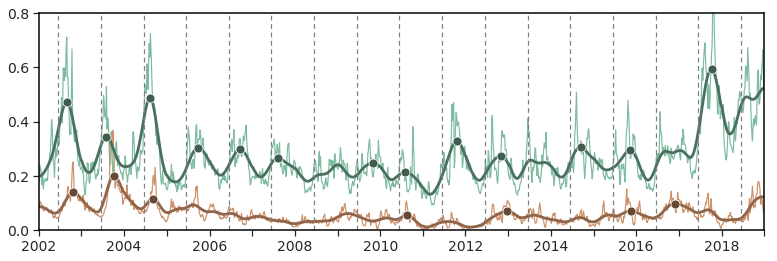

In [36]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.lineplot(dates, BB_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_BB_gc, color='#7ebca1', zorder=1, linewidth=1.2)
    sns.scatterplot(x=dates[time_lag_BB_gc_date], y=BB_gc_smooth[time_lag_BB_gc_date], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, BB_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_BB_cn, color='#ce9169', zorder=1, linewidth=1.2)
    sns.scatterplot(x=dates[time_lag_BB_cn_date], y=BB_cn_smooth[time_lag_BB_cn_date], \
                    color='#674834', zorder=3, s=80)
    
    for i in gc_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
#     ax.set_title('Baffin Bay', fontsize=13)
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
    ax.set(ylim=(0, 0.8), xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_BB.png', bbox_inches='tight', dpi=300)

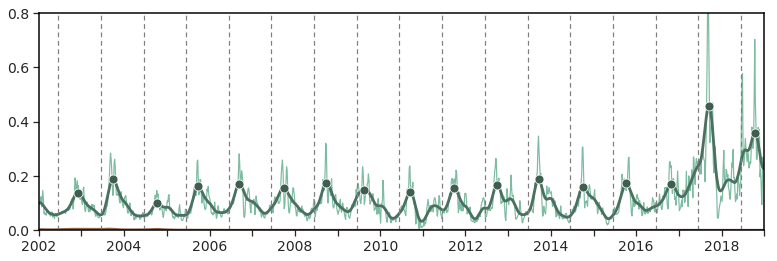

In [253]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.lineplot(dates, N1_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_N1_gc, color='#7ebca1', zorder=1, linewidth=1.2)
#     sns.scatterplot(x=dates[N1_gci], y=N1_gc_smooth[N1_gci], color='#3f5e50', zorder=3, s=80)
    sns.scatterplot(x=dates[time_lag_N1_gc_date], y=N1_gc_smooth[time_lag_N1_gc_date], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, N1_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_N1_cn, color='#ce9169', zorder=1, linewidth=1.2)
    sns.scatterplot(x=dates[N1_cni], y=N1_cn_smooth[N1_cni], color='#674834', zorder=3, s=80)

    for i in gc_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
#     ax.set_title('Nares Strait', fontsize=13)
    ax.set(ylim=(0, 0.8), xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_N1.png', bbox_inches='tight', dpi=300)

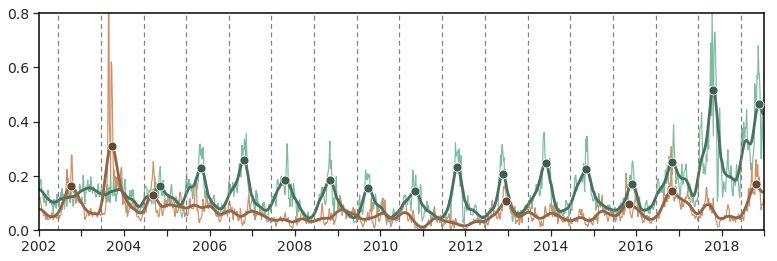

In [254]:
fig = plt.figure(figsize=(13,4))

st = sns.axes_style('ticks')

with st:
    ax = sns.lineplot(dates, PC_gc_smooth, color='#4b7060', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_PC_gc, color='#7ebca1', zorder=1, linewidth=1.2)
    sns.scatterplot(x=dates[time_lag_PC_gc_date], y=PC_gc_smooth[time_lag_PC_gc_date], \
                    color='#3f5e50', zorder=3, s=80)
    
    sns.lineplot(dates, PC_cn_smooth, color='#906549', zorder=2, linewidth=2.8)
    sns.lineplot(dates, norm_PC_cn, color='#ce9169', zorder=1, linewidth=1.2)
    sns.scatterplot(x=dates[time_lag_PC_cn_date], y=PC_cn_smooth[time_lag_PC_cn_date], \
                    color='#674834', zorder=3, s=80)
    sns.scatterplot(x=dt.datetime(2018,10,25), y=[0.17], color='#674834', zorder=3, s=80)
    
    for i in gc_i:
        ax.axvline(months[i], color='#7f7f7f', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
#     ax.set_title('Parry Channel', fontsize=13)
    plt.xticks([dt.datetime(year,1,1) for year in range(2002,2020)])
    ax.set_xticklabels(['2002', '', '2004', '', '2006', '','2008', '', '2010', '', '2012', '', '2014', \
                    '', '2016', '', '2018', ''])
    ax.set(ylim=(0, 0.8), xlim=(dt.datetime(2002,1,1), dt.datetime(2019,1,1)))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');
    
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_PC.png', bbox_inches='tight', dpi=300)

In [37]:
print('Baffin Bay: -----------------------------------')
print('Average lag time (days): ', np.average(time_lag_BB_gc))
print('Maximum lag time (days): ', np.amax(time_lag_BB_gc))
print('Minimum lag time (days): ', np.amin(time_lag_BB_gc))
print('Std of lag time (days):  ', np.std(time_lag_BB_gc))
print('')
print('Nares Strait: ---------------------------------')
print('Average lag time (days): ', np.average(time_lag_N1_gc))
print('Maximum lag time (days): ', np.amax(time_lag_N1_gc))
print('Minimum lag time (days): ', np.amin(time_lag_N1_gc))
print('Std of lag time (days):  ', np.std(time_lag_N1_gc))
print('')
print('Parry Channel: --------------------------------')
print('Average lag time (days): ', np.average(time_lag_PC_gc))
print('Maximum lag time (days): ', np.amax(time_lag_PC_gc))
print('Minimum lag time (days): ', np.amin(time_lag_PC_gc))
print('Std of lag time (days):  ', np.std(time_lag_PC_gc))

Baffin Bay: -----------------------------------
Average lag time (days):  95.53846153846153
Maximum lag time (days):  149
Minimum lag time (days):  49
Std of lag time (days):   34.71779721968233

Nares Strait: ---------------------------------
Average lag time (days):  107.52941176470588
Maximum lag time (days):  169
Minimum lag time (days):  64
Std of lag time (days):   21.266149979441433

Parry Channel: --------------------------------
Average lag time (days):  135.66666666666666
Maximum lag time (days):  164
Minimum lag time (days):  99
Std of lag time (days):   16.29587541544042


In [38]:
print('Baffin Bay: -----------------------------------')
print('Average lag time (days): ', np.average(time_lag_BB_cn))
print('Maximum lag time (days): ', np.amax(time_lag_BB_cn))
print('Minimum lag time (days): ', np.amin(time_lag_BB_cn))
print('Std of lag time (days):  ', np.std(time_lag_BB_cn))
print('')
print('Parry Channel: --------------------------------')
print('Average lag time (days): ', np.average(time_lag_PC_cn))
print('Maximum lag time (days): ', np.amax(time_lag_PC_cn))
print('Minimum lag time (days): ', np.amin(time_lag_PC_cn))
print('Std of lag time (days):  ', np.std(time_lag_PC_cn))

Baffin Bay: -----------------------------------
Average lag time (days):  128.28571428571428
Maximum lag time (days):  189
Minimum lag time (days):  64
Std of lag time (days):   41.26816235901225

Parry Channel: --------------------------------
Average lag time (days):  125.85714285714286
Maximum lag time (days):  184
Minimum lag time (days):  79
Std of lag time (days):   31.881156868365146


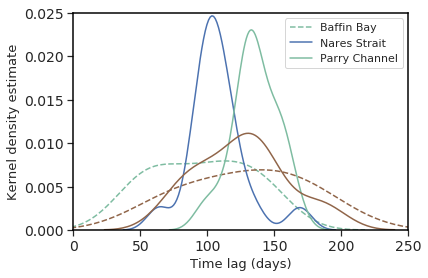

In [207]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_BB_gc, hist=False, color='#7ebca1', label='Baffin Bay', kde_kws={"linestyle":'--'})
    sns.distplot(time_lag_BB_cn, hist=False, color='#906549', kde_kws={"linestyle":'--'})

    sns.distplot(time_lag_N1_gc, hist=False, color='b', label='Nares Strait')

    sns.distplot(time_lag_PC_gc, hist=False, color='#7ebca1', label='Parry Channel')
    sns.distplot(time_lag_PC_cn, hist=False, color='#906549')
    
    ax.set(ylim=(0, 0.025), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

Summary kernel density plot:

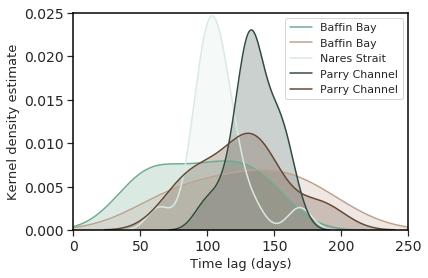

In [228]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.kdeplot(time_lag_BB_gc, shade=True, color='#71a990', label='Baffin Bay')#, kde_kws={"linestyle":'--'})
    sns.kdeplot(time_lag_BB_cn, shade=True, color='#bca291', label='Baffin Bay')

    sns.kdeplot(time_lag_N1_gc, shade=True, color='#d8eae2', label='Nares Strait')

    sns.kdeplot(time_lag_PC_gc, shade=True, color='#324b40', label='Parry Channel')
    sns.kdeplot(time_lag_PC_cn, shade=True, color='#644633', label='Parry Channel')
    
    ax.set(ylim=(0, 0.025), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

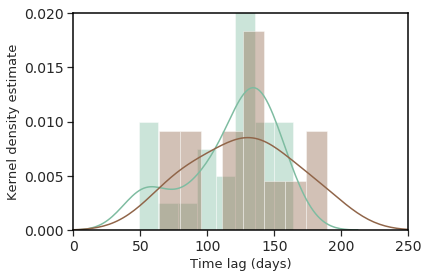

In [205]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_BB_gc+time_lag_PC_gc, hist=True, bins=8, color='#7ebca1')
    sns.distplot(time_lag_BB_cn+time_lag_PC_cn, hist=True, bins=8, color='#906549')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

Time lag difference between continental and glacial arrival in Baffin bay:

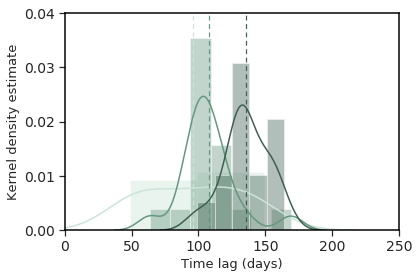

In [227]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_BB_gc, hist=True, color='#cbe4d9', label='Baffin Bay')
    ax.axvline(np.average(time_lag_BB_gc), color='#cbe4d9', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    sns.distplot(time_lag_N1_gc, hist=True, color='#649680', label='Nares Strait')
    ax.axvline(np.average(time_lag_N1_gc), color='#649680', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))

    sns.distplot(time_lag_PC_gc, hist=True, color='#3f5e50', label='Parry Channel')
    ax.axvline(np.average(time_lag_PC_gc), color='#3f5e50', linewidth=1.2, zorder=2, linestyle='--', dashes=(4, 3))
    
    
    ax.set(ylim=(0, 0.04), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

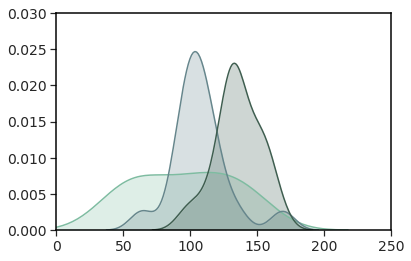

In [45]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.kdeplot(time_lag_BB_gc, shade=True, color='#7ebca1')

    sns.kdeplot(time_lag_N1_gc, shade=True, color='#66868c')

    sns.kdeplot(time_lag_PC_gc, shade=True, color='#3f5e50')

    ax.set(ylim=(0, 0.03), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

#     ax.set_xlabel('Time lag (days)', fontsize=13)
#     ax.set_ylabel('Kernel density estimate', fontsize=13)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_gc_distr.png', bbox_inches='tight', dpi=300)

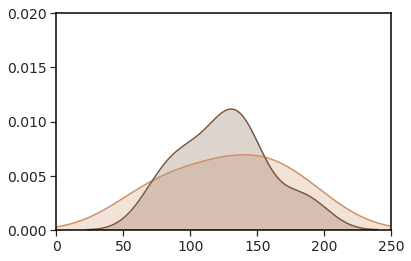

In [41]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.kdeplot(time_lag_BB_cn, shade=True, color='#ce9169')

    sns.kdeplot(time_lag_PC_cn, shade=True, color='#7b573f')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

#     ax.set_xlabel('Time lag (days)', fontsize=13)
#     ax.set_ylabel('Kernel density estimate', fontsize=13)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_cn_distr.png', bbox_inches='tight', dpi=300)

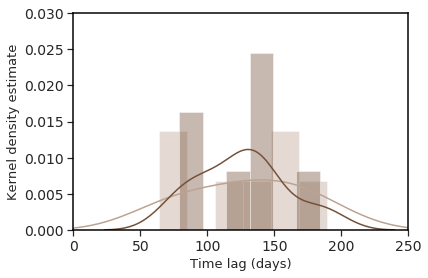

In [226]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_BB_cn, bins=6, hist=True, color='#bca291', label='Baffin Bay')

    sns.distplot(time_lag_PC_cn, bins=6, hist=True, color='#73503a', label='Parry Channel')
    
    ax.set(ylim=(0, 0.03), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

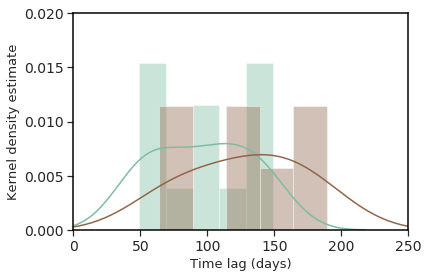

In [203]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_BB_gc, bins=5, hist=True, color='#7ebca1', label='Baffin Bay')
    sns.distplot(time_lag_BB_cn, bins=5, hist=True, color='#906549', label='Baffin Bay')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")

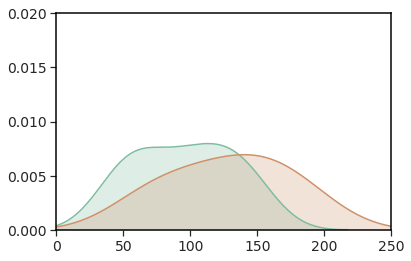

In [47]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.kdeplot(time_lag_BB_gc,shade=True, color='#7ebca1')
    sns.kdeplot(time_lag_BB_cn,shade=True, color='#ce9169')
    
    ax.set(ylim=(0, 0.02), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

#     ax.set_xlabel('Time lag (days)', fontsize=13)
#     ax.set_ylabel('Kernel density estimate', fontsize=13)
    
fig.savefig('/ocean/brogalla/GEOTRACES/figures/time-lag_BB_distr.png', bbox_inches='tight', dpi=300)

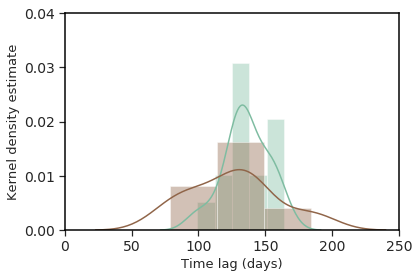

In [204]:
fig = plt.figure(figsize=(6,4))

st = sns.axes_style("ticks")

with st:
    ax = sns.distplot(time_lag_PC_gc, hist=True, color='#7ebca1')
    sns.distplot(time_lag_PC_cn, hist=True, color='#906549')
    
    ax.set(ylim=(0, 0.04), xlim=(0,250))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.spines['left'].set_linewidth(1.5);   ax.spines['left'].set_color('black');
    ax.spines['bottom'].set_linewidth(1.5); ax.spines['bottom'].set_color('black');
    ax.spines['right'].set_linewidth(1.5);  ax.spines['right'].set_color('black');
    ax.spines['top'].set_linewidth(1.5);    ax.spines['top'].set_color('black');

    ax.set_xlabel('Time lag (days)', fontsize=13)
    ax.set_ylabel('Kernel density estimate', fontsize=13)
# plt.savefig("/ocean/brogalla/GEOTRACES/figures/BB-time-lag-20191003.png")